<a href="https://colab.research.google.com/github/PaoloSani/SASP-Project/blob/First-attempt/Speech_dereverberation_using_Cepstrum_alanysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import IPython.display as ipd

plt.style.use('seaborn')

# **Load the clean voice recording and the IR**




In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/SASP-Project"
%ls

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/SASP-Project'
/content
drive/  sample_data/


In [3]:
# path to the folder in drive
path = "/content/drive/MyDrive/SASP Project"

In [ ]:
voice, Fs = librosa.load(path + "/singing.wav", sr=None)
ir, Fs_ir = librosa.load(path + "/spokane_womans_club_ir.wav", sr=None, mono=False)


In [ ]:
ipd.display(ipd.Audio(voice, rate=Fs))

# **Create the new reverbered audio**

In [ ]:
t_end = int(np.ceil(1.5*Fs))
signal_dry = voice[0:t_end]     # shorten the original audio file

In [ ]:
ipd.display(ipd.Audio(signal_dry, rate=Fs))

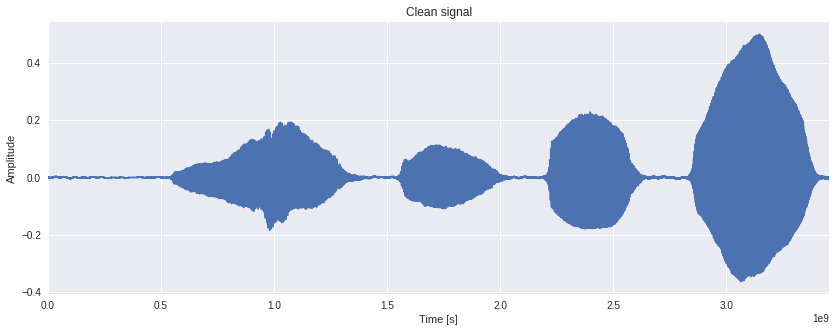

In [ ]:
signal_dry_length = signal_dry.shape[-1]
t_instants = np.arange(0,signal_dry_length) * Fs
final_duration = signal_dry_length/Fs

plt.figure(figsize=(14,5))
plt.plot(t_instants,signal_dry)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Clean signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

In [ ]:
signal_wet = np.array([np.convolve(signal_dry, ir[0,:]),
              np.convolve(signal_dry, ir[1,:])]).T

# normalize the obtained audio
signal_wet = signal_wet / np.max(signal_wet)

# shorten the file 
t_end = int(np.ceil(4.4*Fs))
signal_wet = signal_wet[0:t_end]
signal_wet.shape 


(211201, 2)

In [ ]:
ipd.display(ipd.Audio(signal_wet.T, rate=Fs))

Finally, save the new reverbered file:


In [ ]:
import soundfile as sf
sf.write(path+"/reverbered_voice.wav", signal_wet, samplerate=Fs)

# **Process the audio file**

In [4]:
# load the audio file (as MONO)
signal, Fs = librosa.load(path + "/reverbered_voice.wav", sr=None)

ipd.display(ipd.Audio(signal, rate=Fs))

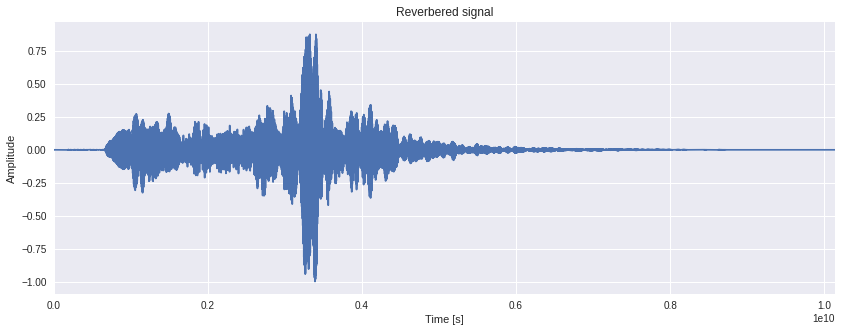

In [5]:
signal_length = len(signal)

t_instants = np.arange(0,signal_length) * Fs
final_duration = signal_length/Fs

plt.figure(figsize=(14,5))
plt.plot(t_instants,signal)
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Reverbered signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

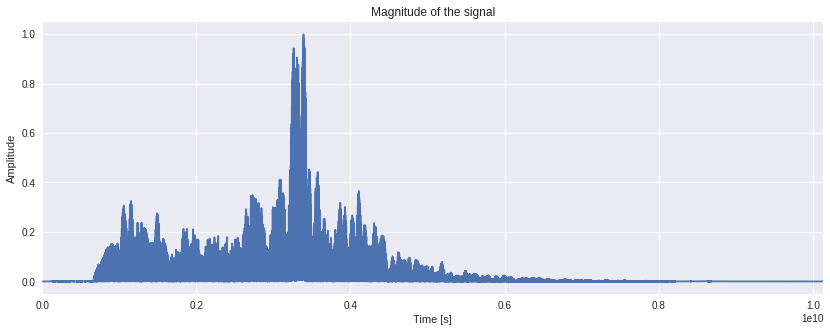

In [6]:
plt.figure(figsize=(14,5))
plt.plot(t_instants,np.abs(signal))
plt.xlabel('Time [s]');
plt.ylabel('Amplitude');
plt.title('Magnitude of the signal');
plt.autoscale(enable=True, axis= 'x', tight =True)

In [7]:
# SEGMENTATION by eye
segments = np.vstack([[0.23, 0.62],
            [0.66, 0.89],
            [0.95, 1.15],
            [1.22, 1.5]])
segments[:,0]



array([0.23, 0.66, 0.95, 1.22])

In [8]:
# auxiliary function
def nextpow2(i):
    n = 1
    while n < i: n *= 2
    return n

In [9]:
limits_idx = np.zeros((4,2))

start_idx = (segments[:,0]*Fs).astype(int)
stop_idx = (segments[:,1]*Fs).astype(int)
limits_idx = np.vstack([start_idx, stop_idx])
print(limits_idx) 

durations = (limits_idx[1,:] - limits_idx[0,:])

durations = list(map(nextpow2, durations))
print(durations)

max_frame_size = np.max(durations);

frames = np.zeros((4,max_frame_size));
limits_idx[1,:] = limits_idx[0,:] + durations;


[[11040 31680 45600 58560]
 [29760 42720 55199 72000]]
[32768, 16384, 16384, 16384]


(4, 32768)
(4, 32768)
(4, 32768)
(4, 32768)


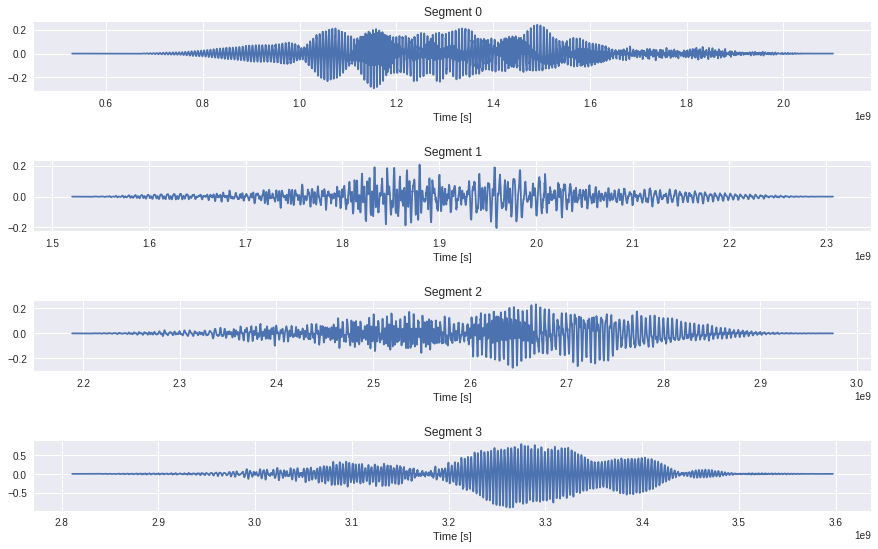

In [23]:
plt.figure(figsize=(15,9))
for i in range(len(segments)):
  plt.subplot(4,1,i+1);

  t = t_instants[limits_idx[0,i] : limits_idx[1,i]];
  frame = signal[limits_idx[0,i] : limits_idx[1,i]];
  print(frames.shape)
  frames[i, 0:durations[i]] = frame;

  win = np.hanning(frame.shape[0])
  frame = win*frame
  # TODO: exponential window + exponential weighting

  plt.plot(t, frame)
  plt.xlabel('Time [s]')
  plt.title('Segment {}' .format(i))
  plt.subplots_adjust(hspace=1)
  plt.subplots_adjust(wspace = 0.5)

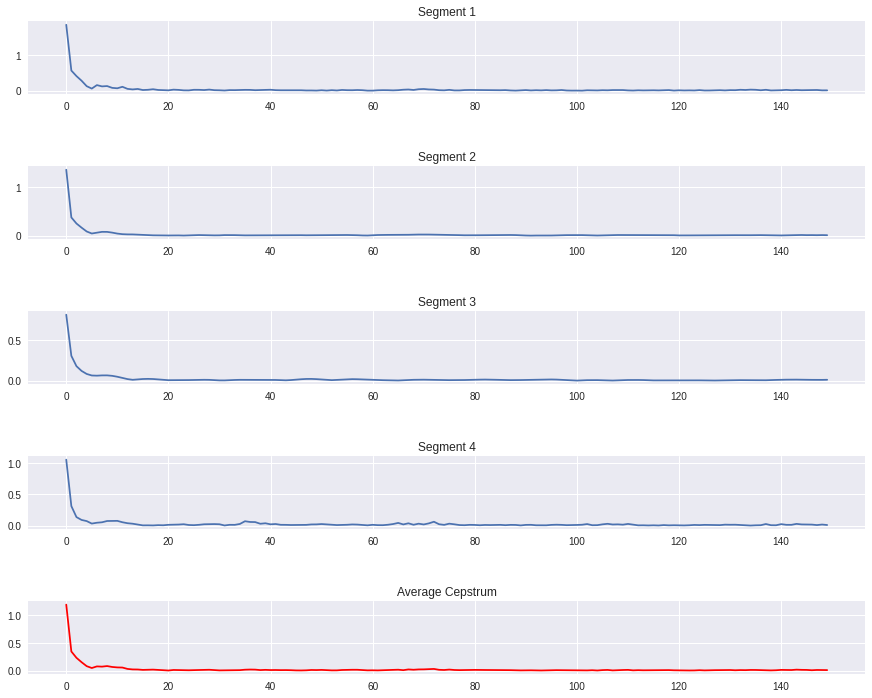

In [51]:
max_quefrency_bin = 150
avg_Cepstrum = np.zeros((4, max_quefrency_bin), dtype = 'complex_')

plt.figure(figsize=(15,12))
for i in range(len(segments)):
  plt.subplot(5,1,i+1);
  X = np.fft.fft(frames[i, :])
  L = len(X)
  X = X[0 : round(L/2) + 1]
  Cepstrum = np.fft.ifft(np.log10(X))

  # TODO: unwrapping is missing

  Cepstrum = Cepstrum[0:max_quefrency_bin];
  quefrency = range(len(Cepstrum));
  plt.plot(quefrency,abs(Cepstrum))
  avg_Cepstrum[i,:] = Cepstrum;
  plt.title("Segment {}" .format(i+1));


avg_Cepstrum = np.sum(avg_Cepstrum,0)/4;
plt.subplot(5,1,5)
plt.plot(quefrency, np.abs(avg_Cepstrum), 'r');
plt.title("Average Cepstrum");
plt.subplots_adjust(hspace=1)
plt.subplots_adjust(wspace = 0.5)